In [2]:
import pandas as pd
import numpy as np
from pandas.io.data import DataReader
from pandas.io.data import get_data_yahoo
from datetime import datetime

startTime = datetime(2000,1,1)
endTime = datetime(2016,8,20)
company = 'GOOG' ## Can be changed to AAPL, YAHOO, etc.

print startTime
print endTime
print company

2000-01-01 00:00:00
2016-08-20 00:00:00
GOOG


C:\Users\Abhinav\AppData\Local\Enthought\Canopy\User\lib\site-packages\pandas\io\data.py:35: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


In [3]:
def getStockData(symbol, start, end, getVolume=False):
    """Downloading Stock data from Yahoo Finance dataset from pandas method 
       and calculate daily returns based on Adj Close column"""
    df = get_data_yahoo(symbol, start, end)

    df.rename(columns = {'Adj Close' : 'Closing' + '_' + symbol}, inplace=True)
    
    ed = -2 if getVolume else -1
    return df.drop(df.columns[:ed], axis = 1)

In [4]:
# NASDAQ Composite (^IXIC)
# Dow Jones Industrial Average (^DJI)
# Frankfurt DAX (^GDAXI)
# Paris CAC 40 (^FCHI)
# Tokyo Nikkei-225 (^N225)
# Hong Kong Hang Seng (^HSI)
# Australia ASX-200 (^AXJO)
indices_list = [company,'^IXIC','^DJI','^GSPC','^GDAXI','^N225','^HSI','^AXJO']
#print indices_list
raw_data = []
raw_data.append(getStockData(indices_list[0], startTime, endTime, getVolume=True))
volume_data = raw_data[0].Volume
raw_data[0] = raw_data[0].drop(raw_data[0].columns[0], axis = 1)

for indice in indices_list[1:]:
    raw_data.append(getStockData(indice, startTime, endTime, getVolume=False))

print raw_data[0].head(), "\n",volume_data.head()


            Closing_GOOG
Date                    
2004-08-19     50.119968
2004-08-20     54.100990
2004-08-23     54.645447
2004-08-24     52.382705
2004-08-25     52.947145 
Date
2004-08-19    44871300
2004-08-20    22942800
2004-08-23    18342800
2004-08-24    15319700
2004-08-25     9232100
Name: Volume, dtype: int64


In [5]:
## parameters

N_history = 15
forcast = 5 # Days system will predict
return_eval_list = [1,2,3,5,8,13]
avg_return_span_list = return_eval_list[1:]
volume_rolling_win = N_history * forcast
PCA_n = 10

meg_data = pd.concat(raw_data, axis=1, join='inner')
print volume_data.tail()
print meg_data.tail()
for i in range(len(raw_data)):
    for j in range(N_history):
        t = forcast * (j + 1);
        meg_data[meg_data.columns.values[i] + str(t)] = meg_data.iloc[:, i].shift(t)

#print volume_rolling_win        
print "\n Merged Data with past",N_history,"day records as features: \n",meg_data.columns.values, '\n', meg_data.head()

## Generating return and average return over a list of time

returnList = forcast * np.array(return_eval_list)
avgReturnList = forcast * np.array(avg_return_span_list)
print "\n Return calculation list \n",returnList
print "\n Avg. return calculation list \n",avgReturnList

return_data = pd.DataFrame()
return_data['return'] = meg_data.iloc[:,0].pct_change(returnList[0])

for i in returnList[1:]:
    return_data['return'+str(i)] = meg_data.iloc[:,0].pct_change(i)

for i in avgReturnList:
    return_data['avgReturn'+str(i)] = return_data['return'].rolling(i).mean()
    
print "\nReturn data \n", return_data.tail()

## Normalize Volume Data and compare to its standard deviation

volume_norm = (volume_data - volume_data.rolling(volume_rolling_win).mean()) / volume_data.rolling(volume_rolling_win).std()
print "\nRolling volume \n", volume_norm.tail()

Date
2016-08-15     936600
2016-08-16    1027100
2016-08-17     921400
2016-08-18     718400
2016-08-19     849900
Name: Volume, dtype: int64
            Closing_GOOG  Closing_^IXIC  Closing_^DJI  Closing_^GSPC  \
Date                                                                   
2016-08-15    782.440002    5262.020020  18636.050781    2190.149902   
2016-08-16    777.140015    5227.109863  18552.019531    2178.149902   
2016-08-17    779.909973    5228.660156  18573.939453    2182.219971   
2016-08-18    777.500000    5240.149902  18597.699219    2187.020020   
2016-08-19    775.419983    5238.379883  18552.570312    2183.870117   

            Closing_^GDAXI  Closing_^N225  Closing_^HSI  Closing_^AXJO  
Date                                                                    
2016-08-15    10739.209961   16869.560547  22932.509766    5540.000000  
2016-08-16    10676.650391   16596.509766  22910.839844    5532.000000  
2016-08-17    10537.669922   16745.640625  22799.779297    55

In [7]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
from sklearn.decomposition import pca

def pca_result(good_data, pca):

    dimensions = ['Dim {}'.format(i) for i in range(1,len(pca.components_)+1)]

    components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
    components.index = dimensions

    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Variance'])
    variance_ratios.index = dimensions

    fig, ax = plt.subplots(figsize = (14,8))

    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)

    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Variance\n          %.4f"%(ev))

    return pd.concat([variance_ratios, components], axis = 1)

In [8]:
from IPython.display import display
from sklearn.decomposition import PCA

# Data scaling
meg_data = meg_data.dropna()
log_data = np.log(meg_data)

pca = PCA(n_components = PCA_n)
pca.fit(log_data)
print "PCA explained variance ratio = ", pca.explained_variance_ratio_

#pca_result(log_data, pca)
pca_results = pca_result(log_data, pca)

reduced_data = pca.transform(log_data)
reduced_data = pd.DataFrame(reduced_data, index=log_data.index)

data = pd.concat([reduced_data, return_data, volume_norm], axis=1, join='inner')
data = data.dropna()

## Labeling

y_raw = return_data['return'].shift(-returnList[0])
comp = lambda x: (1 if x > 0 else -1)
y_raw = y_raw.apply(comp)
print y_raw

x_endtime = data.iloc[-1]    #last day feature used for stock prediction
data = data.drop(data.index[-returnList[0]:], axis = 0)    
y = pd.Series(y_raw, index = data.index)    

print "\n Train/Test data: ", data.shape, "\n", data.tail(volume_rolling_win),'\n',data.columns.values
print "Stock Return:", data['return']
print "\n Labels: ", y.shape, "\n", y

PCA explained variance ratio =  [ 0.81195493  0.0981082   0.03537025  0.01931532  0.01382488  0.00370724
  0.00279115  0.00222315  0.0016988   0.00141276]
Date
2004-08-19    1
2004-08-20   -1
2004-08-23   -1
2004-08-24   -1
2004-08-25   -1
2004-08-26   -1
2004-08-27   -1
2004-08-30   -1
2004-08-31   -1
2004-09-01    1
2004-09-02    1
2004-09-03    1
2004-09-07    1
2004-09-08    1
2004-09-09    1
2004-09-10    1
2004-09-13    1
2004-09-14    1
2004-09-15    1
2004-09-16    1
2004-09-17    1
2004-09-21    1
2004-09-22    1
2004-09-24    1
2004-09-27    1
2004-09-28    1
2004-09-30    1
2004-10-04    1
2004-10-05    1
2004-10-06    1
             ..
2016-07-06    1
2016-07-07    1
2016-07-08    1
2016-07-11    1
2016-07-12    1
2016-07-13    1
2016-07-14    1
2016-07-15    1
2016-07-19    1
2016-07-20    1
2016-07-21    1
2016-07-22    1
2016-07-25    1
2016-07-26    1
2016-07-27    1
2016-07-28    1
2016-07-29    1
2016-08-01    1
2016-08-03    1
2016-08-04    1
2016-08-05    1
2016-08-

In [8]:
# TODO: Split the data into training and testing sets using the given feature as the target
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.25, random_state=42)


In [9]:
%matplotlib inline 
from time import time
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV

def fa_score(ytrue, ypred, pos_label=1):
    return min(f1_score(ytrue, ypred, pos_label=1), accuracy_score(ytrue, ypred))

def train_classifier(clf, X_train, y_train, gridSearch=False, parameters=None):
    
    print X_train.shape, y_train.shape
    if not gridSearch:
        clf.fit(X_train, y_train)
    else:
        f1_scorer = make_scorer(f1_score, pos_label=1)
        accu_scorer = make_scorer(accuracy_score)
        fa_scorer = make_scorer(fa_score)
        grid_obj = GridSearchCV(clf, parameters, scoring = fa_scorer)
        grid_obj.fit(X_train, y_train)
        print "GridSearch Best Parameters: ", grid_obj.best_params_, '=', grid_obj.best_score_
        clf = grid_obj.best_estimator_
    
    return clf
    
def predict_labels(clf, features, target):

    y_pred = clf.predict(features)
    return f1_score(target.values, y_pred, pos_label=1), accuracy_score(target.values, y_pred),\
            recall_score(target.values, y_pred), precision_score(target.values, y_pred)


def train_predict(clf, X_train, y_train, X_test, y_test, gridSearch=False, parameters=None):

    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    clf = train_classifier(clf, X_train, y_train, gridSearch, parameters)
    
    f1train, atrain, rtrain, ptrain = predict_labels(clf, X_train, y_train)
    print "For training set:",'\naccuracy =',atrain, '\nprecision =', ptrain, '\nrecall =', rtrain, '\nf1 =',f1train
    f1test, atest, rtest, ptest = predict_labels(clf, X_test, y_test)
    print "For testing set:",'\naccuracy =',atest, '\nprecision =', ptest, '\nrecall =', rtest, '\nf1 =',f1test
    
    return clf, min(f1test,atest)
    
def plotROC(clf, X_test, y_test):
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)
    print 'ROC AUC: %0.2f' % roc_auc
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
def compBestClf(clf_cand, score_cand, clf_best, score_best):
    if score_cand > score_best: 
        score_best = score_cand
        clf_best = clf_cand
    return clf_best, score_best

# Variables to compare and find best classifier model
clf_best = None
score_best = 0

Training a AdaBoostClassifier using a training set size of 1984. . .
(1984, 22) (1984L,)
GridSearch Best Parameters:  {'n_estimators': 50, 'learning_rate': 1} = 0.592237903226
For training set: 
accuracy = 0.697076612903 
precision = 0.698388334612 
recall = 0.813953488372 
f1 = 0.751755472945
For testing set: 
accuracy = 0.610271903323 
precision = 0.610208816705 
recall = 0.745042492918 
f1 = 0.670918367347
ROC AUC: 0.66


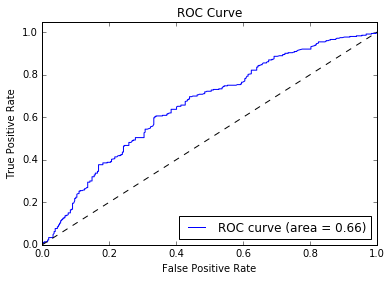

In [10]:
from sklearn.ensemble import AdaBoostClassifier

clf_Bst = AdaBoostClassifier(n_estimators=20)

param_Bst = {'n_estimators': [2, 3, 5, 10, 20, 50], 'learning_rate': [0.1, 0.5, 1]}
clf_Bst, f1_Bst = train_predict(clf_Bst, X_train, y_train, X_test, y_test, gridSearch=True, parameters = param_Bst)

plotROC(clf_Bst, X_test, y_test)

clf_best, score_best = compBestClf(clf_Bst, f1_Bst, clf_best, score_best)

Training a RandomForestClassifier using a training set size of 1984. . .
(1984, 22) (1984L,)
GridSearch Best Parameters:  {'n_estimators': 80, 'max_depth': 8} = 0.690524193548
For training set: 
accuracy = 0.901713709677 
precision = 0.859703819174 
recall = 0.986583184258 
f1 = 0.918783840067
For testing set: 
accuracy = 0.703927492447 
precision = 0.667377398721 
recall = 0.886685552408 
f1 = 0.761557177616
ROC AUC: 0.79


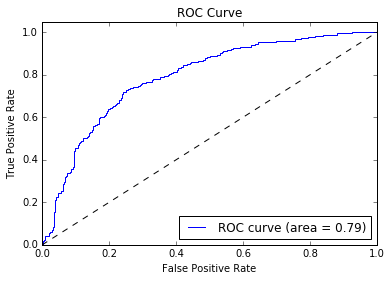

In [11]:
from sklearn.ensemble import RandomForestClassifier

clf_RF = RandomForestClassifier(n_estimators=10, n_jobs=-1)

param_RF = {'n_estimators': [5, 10, 20, 40, 80, 160], 'max_depth': [2,3,4,8]}
clf_RF, f1_RF = train_predict(clf_RF, X_train, y_train, X_test, y_test, gridSearch=True, parameters = param_RF)

plotROC(clf_RF, X_test, y_test)

clf_best, score_best = compBestClf(clf_RF, f1_RF, clf_best, score_best)

Training a GaussianNB using a training set size of 1984. . .
(1984, 22) (1984L,)
For training set: 
accuracy = 0.571068548387 
precision = 0.596112311015 
recall = 0.74060822898 
f1 = 0.660550458716
For testing set: 
accuracy = 0.540785498489 
precision = 0.552016985138 
recall = 0.736543909348 
f1 = 0.631067961165
ROC AUC: 0.56


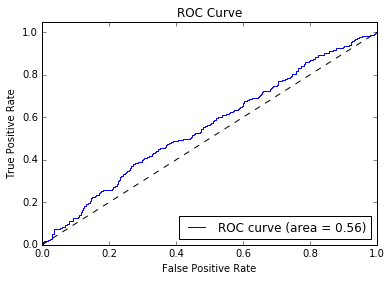

In [12]:
from sklearn.naive_bayes import GaussianNB

clf_NB = GaussianNB()

clf_NB, f1_NB = train_predict(clf_NB, X_train, y_train, X_test, y_test)

plotROC(clf_NB, X_test, y_test)

clf_best, score_best = compBestClf(clf_NB, f1_NB, clf_best, score_best)

Training a DecisionTreeClassifier using a training set size of 1984. . .
(1984, 22) (1984L,)
GridSearch Best Parameters:  {'min_samples_split': 5, 'max_depth': 8} = 0.619959677419
For training set: 
accuracy = 0.678931451613 
precision = 0.793650793651 
recall = 0.581395348837 
f1 = 0.671140939597
For testing set: 
accuracy = 0.584592145015 
precision = 0.644444444444 
recall = 0.492917847025 
f1 = 0.558587479936
ROC AUC: 0.63


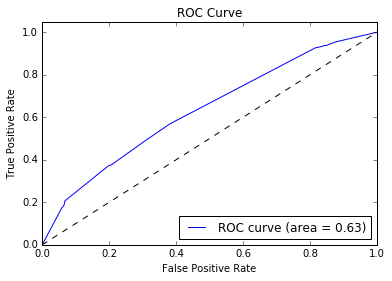

In [13]:
from sklearn.tree import DecisionTreeClassifier

clf_DT = DecisionTreeClassifier(random_state=0, min_samples_split=80)

param_DT = {'min_samples_split': [2,5,10,50,100,200], 'max_depth': [2,3,5,8]}
clf_DT, f1_DT = train_predict(clf_DT, X_train, y_train, X_test, y_test, gridSearch=True, parameters = param_DT)

plotROC(clf_DT, X_test, y_test)

# compare best clf
clf_best, score_best = compBestClf(clf_DT, f1_DT, clf_best, score_best)

Training a KNeighborsClassifier using a training set size of 1984. . .
(1984, 22) (1984L,)
GridSearch Best Parameters:  {'n_neighbors': 8} = 0.610383064516
For training set: 
accuracy = 0.722782258065 
precision = 0.787449392713 
recall = 0.695885509839 
f1 = 0.738841405508
For testing set: 
accuracy = 0.616314199396 
precision = 0.644314868805 
recall = 0.626062322946 
f1 = 0.635057471264
ROC AUC: 0.67


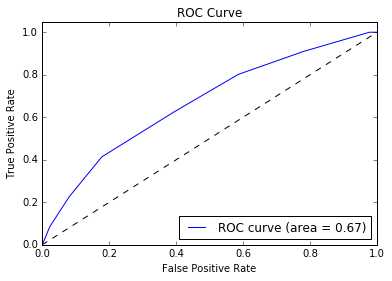

In [14]:
from sklearn.neighbors import KNeighborsClassifier

clf_KNN = KNeighborsClassifier(n_neighbors=4)

param_KNN = {'n_neighbors':[2,4,8,16,32]}
clf_KNN, f1_KNN = train_predict(clf_KNN, X_train, y_train, X_test, y_test, gridSearch=True, parameters = param_KNN)

plotROC(clf_KNN, X_test, y_test)
             
clf_best, score_best = compBestClf(clf_KNN, f1_KNN, clf_best, score_best)

Best Classifier is: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Best Classifier's Score on test:  0.703927492447
ROC AUC: 0.79


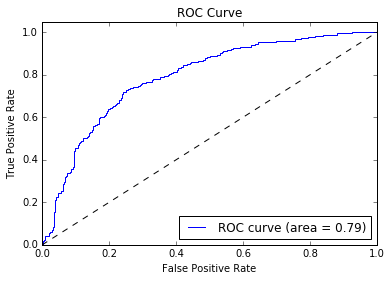

FORCAST [days]: 5
END TIME: 2016-08-20 00:00:00

SYMBOL		TREND		MODEL FA SCORE		FALL/RISE CONFIDENCE
GOOG 		FALL 		0.703927492447 		[[ 0.51142743  0.48857257]]
Predict: 
GOOG stock after 5 days of 2016-08-19 00:00:00 is going to (with confidence FALL/RISE = [[ 0.51142743  0.48857257]] ): FALL


In [15]:
## Classifier summary

print "Best Classifier is: \n", clf_best
print "Best Classifier's Score on test: ", score_best

plotROC(clf_best, X_test, y_test)

x_endtime_row = x_endtime.reshape(1, -1)
pred_v = clf_best.predict(x_endtime_row)
pred_p = clf_best.predict_proba(x_endtime_row)
pred_str = "RISE" if pred_v > 0 else "FALL"

print "FORCAST [days]:", forcast
print "END TIME:", endTime
print "\nSYMBOL\t\tTREND\t\tMODEL FA SCORE\t\tFALL/RISE CONFIDENCE"
print company, '\t\t', pred_str, '\t\t', score_best, '\t\t', pred_p
    
print "Predict: \n", company, "stock after", forcast, "days of", x_endtime.name, \
    "is going to (with confidence FALL/RISE =", pred_p, "):" , pred_str